<a href="https://colab.research.google.com/github/antfolk/BMEF20/blob/main/EMG_classification_tutorial/BMEF20_EMG_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial: EMG classification

## Summary
In this tutorial, you will see a simple example of how machine learning methods can be used to infer motion intent from electromyography data — a problem of interest for intuitive and dexterous control interfaces for powered upper-limb prostheses. In particular, you will see how Python, together with some relevant libraries, can be used to:

*   format electromyography data for use with pattern recognition algorithms.
*   extract discriminative features from the surface electromyogram.
*   train and use machine learning models to infer motion intent from such EMG features.
*   evaluate the performance of a model trained in this way.


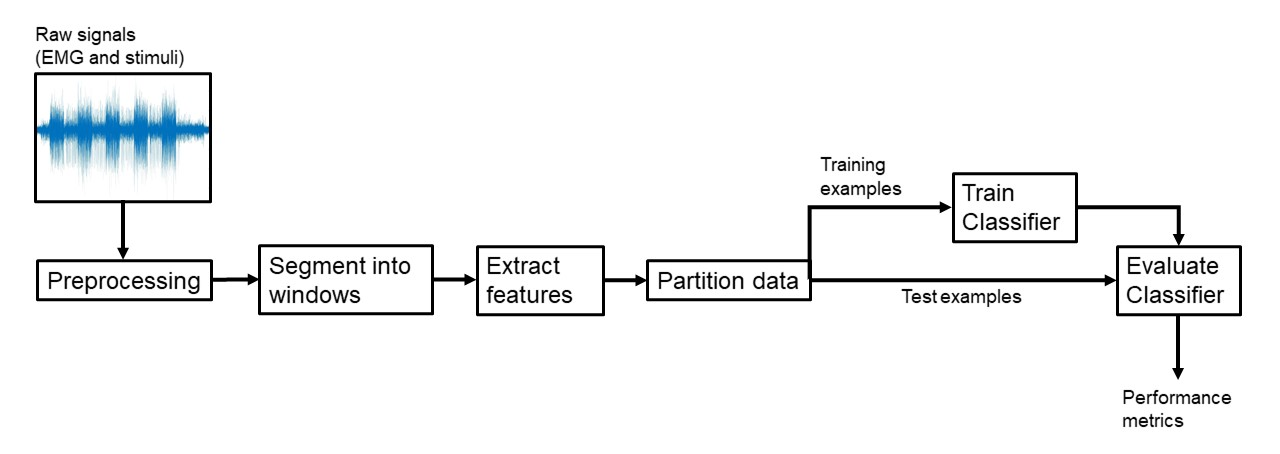
Figure 1. The data processing pipeline of this tutorial.


The numpy library will be used to represent and perform operations on signals. The pyplot library will be used for plotting and visualization.

In [ ]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# Introduction
In humans, movements of the hand and wrist are mainly effectuated by extrinsic muscles — muscles located in the forearm that exert force at the level of the bones in the hand, which they are connected to via long tendons. The aggegation of muscle action potentials produced when such muscles contract voluntarily gives rise to detectable electrical activity at the level of the skin, the recording of which is known as surface electromyography (EMG).

Transradial amputees by definition lack the actual hand and wrist, but typically retain most of the extrinsic muscles of the hand. Importantly, as these muscles are still innervated, the amputee can voluntarily contract them. This is the basis for upper-limb *myoelectric prostheses*, i.e. a category of prosthetic hands that are controlled with EMG. The far most common type of control for this kind of prosthesis is referred to as *direct control*: the respective activities of an agonist-antagonist muscle pair is used to drive a single motorized degree of freedom, e.g. the opening/closing of a fist. Such interfaces cannot be said to be intuitive: the pattern of contraction required to produce a motion does not correspond to the pattern of contraction that same motion would require by someone with an intact limb. 

Here we will consider an alternative, more recent type of control interface for myoelectric prostheses, typically referred to as *myoelectric pattern recognition*. Within this framework, EMG is not used to drive some actuator directly — instead, machine learning algorithms are *trained* to recognize patterns in EMG assosciated with specific gestures and motions. When such a pattern is detected, a command to perform the corresponding motion can be sent to the prosthetic. The theoretical advantage of this framework over the direct control approach is quite apparent: control of the limb can become entirely natural. However, training a *classifier* for this kind of task requires a labelled dataset consisting of examples of EMG signals with known concurrent movement intent. 


# Data
The NinaPro project [1] is a collection of publically available EMG databases created with the intent to simplify development of novel motion-decoding algorithms for use with muscle-computer interfaces. The data we will utilize in this tutorial is a part of the DB2 sub-database and originates from a single intact (i.e. non-amputee) subject. It consists of forearm EMG, together with information on kinematics, collected from the subject while performing a selection of 17 motions and gestures (shown in figure 2) considered particularly important for activities of daily living.

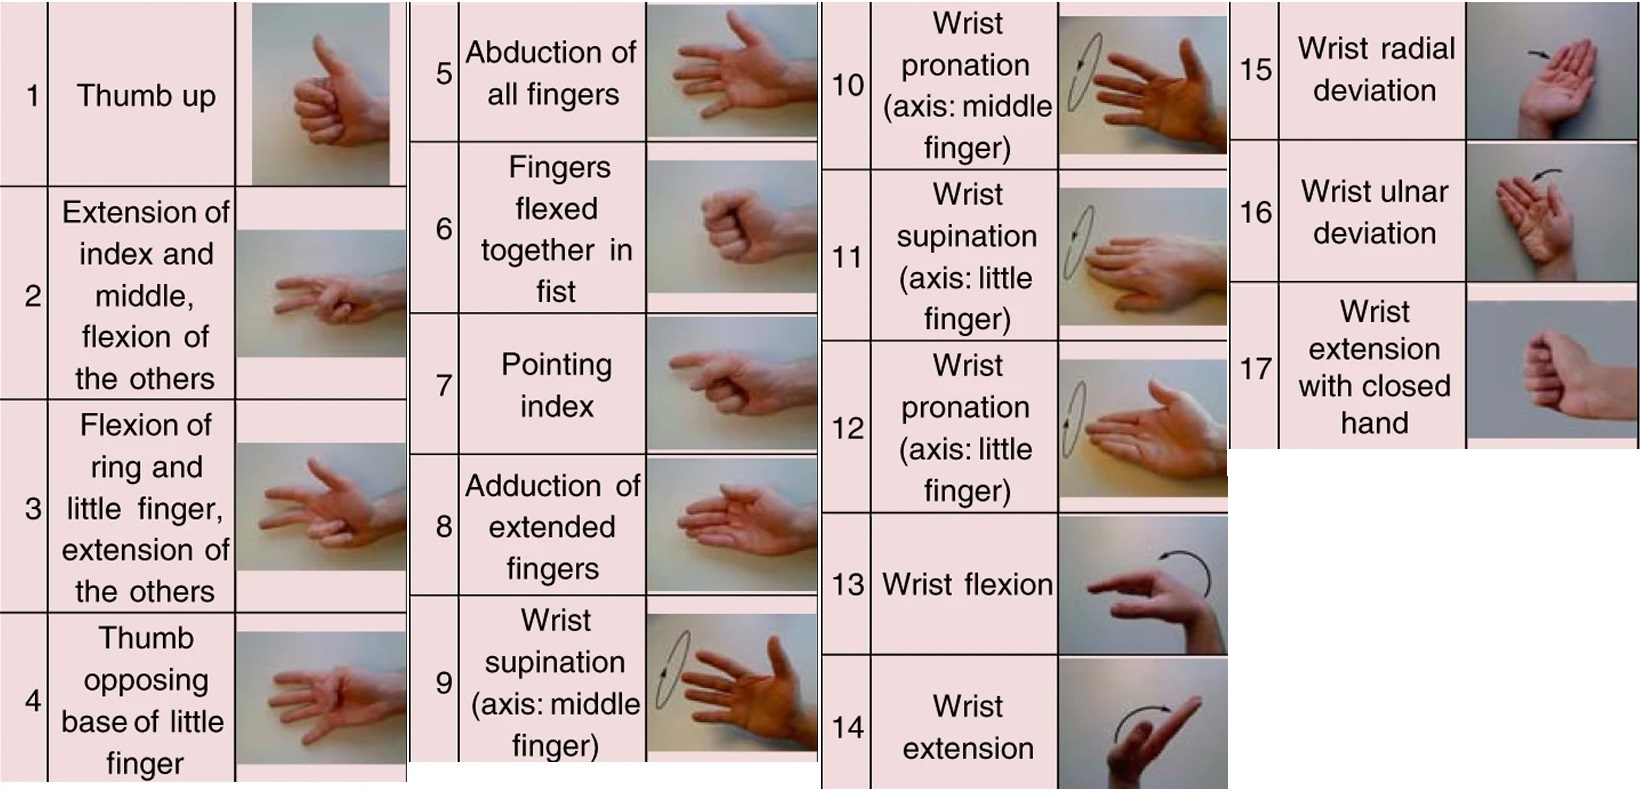

Figure 2. The selection of motions and grasps performed during data acquisition for the relevant NinaPro sub-database, and their respective integer encodings.

To start off, we need to upload the file that contains the aforementioed NinaPro data. Run the code block below — when the 'Choose Files' button appears, click it and select the 'signals.mat' file. (Uploading the file may take a while, be patient)

In [ ]:
names = !ls -al
for name in names:
  if 'signals.mat' in name:
    !rm 'signals.mat'

from google.colab import files
_ = files.upload()

Saving signals.mat to signals.mat


We will use the scipy.io library to load the .mat file into runtime memory:

In [ ]:
from scipy.io import loadmat
mat = loadmat('signals.mat')

emg = mat['emg']
print('Shape of emg variable: {}'.format(emg.shape))

stimulus = mat['stimulus']
print('Shape of stimulus variable: {}'.format(stimulus.shape))

repetition = mat['repetition']
print('Shape of repetition variable: {}'.format(repetition.shape))

Shape of emg variable: (1808331, 12)
Shape of stimulus variable: (1808331, 1)
Shape of repetition variable: (1808331, 1)


The relevant data is composed of 3 signals, represented by the variables *emg*, *stimulus*, and *repetition*, respectively. The *emg* variable contains the 12-channel forearm EMG sampled at a rate of 2 kHz from the forearm of the subject. The *stimulus* variable contains an integer representation of the concurrent visual cue used to promt the subject to perform motions, synchronized  sample-wise with emg. The auxiliary *repetition* variable contains the per-sample repetition affiliation, i.e. from which repetition of the motion the corresponding emg sample was taken. In other words, if *stimulus*[t]=*m* and *repetition*[t]=*n*, then *emg*[t, :] represents an EMG sample (consisting of voltages) collected during the n:th repetition of the m:th movement. The motion represented by each integer *m* can be read from figure 2.

With all this in mind, we define and print some useful constants:

In [ ]:
fs = 2e3 #sampling rate
time_step = 1 / fs

L = emg.shape[0] #total samples
time = np.arange(0,L*time_step,time_step) #times since experiment start

num_channels = emg.shape[1]

num_motions = np.unique(stimulus).size
repetitions_per_motion = np.unique(repetition).size

print('Total duration of data acquisition was {:.0f} s'.format(time[-1]))
print('Number of EMG channels is {:.0f}'.format(num_channels))
print('Number of unique motions (including rest) is {:.0f}'.format(num_motions))
print('Each motion was repeated {:.0f} times'.format(repetitions_per_motion))


Total duration of data acquisition was 904 s
Number of EMG channels is 12
Number of unique motions (including rest) is 18
Each motion was repeated 6 times


For the purpose of visualizing a representative part the signals, we define a view window corresponding to the first 160 s (320000 samples). As we shall see, this time interval contains motions 1-3 of the dataset.

In [ ]:
view_window = np.arange(0,320000,1)

We plot the values of the stimulus variable in this interval:

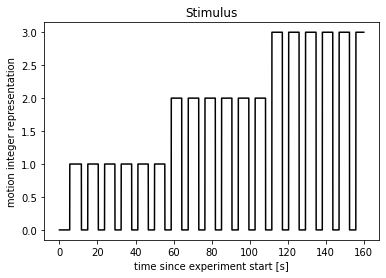

In [ ]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
_ = ax.plot(time[view_window],
            stimulus[view_window],
            color='black')
_ = ax.set_title('Stimulus')
_ = ax.set_xlabel('time since experiment start [s]')
_ = ax.set_ylabel('motion integer representation')

As can be seen, each motion is repeated 6 times, with each motion repetition lasting for a duration of 5 s, with 3 s of rest intersperced between each repetition (a stimulus value of 0 here signifies no motion being prompted, i.e. the subject being in a resting state). The remainder of the stimulus signal outside the view window has identical structure, with motions 4-17 also being repeated 6 times each. 

Next, we take a look at the repetition variable:

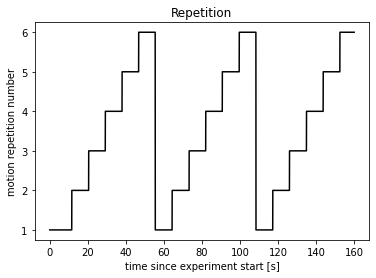

In [ ]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
_ = ax.plot(time[view_window],
            repetition[view_window],
            color='black')
_ = ax.set_title('Repetition')
_ = ax.set_xlabel('time since experiment start [s]')
_ = ax.set_ylabel('motion repetition number')

This variable keeps track of which repetition each time sample belongs to. Notice that the 3 s of rest preceding each motion onset is labeled as being a part of that repetition.

Lastly, we can plot the 12 channels of the EMG signal in the same figure:

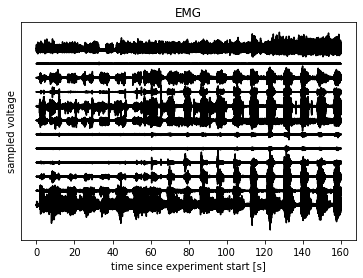

In [ ]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
for channel in range(num_channels):
  offset = channel*np.percentile(emg, 99.95)
  _ = ax.plot(time[view_window],
              emg[view_window, channel] + offset,
              color='black')
_ = ax.set_title('EMG')
_ = ax.set_xlabel('time since experiment start [s]')
_ = ax.set_ylabel('sampled voltage')
_ = ax.get_yaxis().set_ticks([])

By comparing this with the previous plots, we can conclude that pulses of high EMG activity coincide with motion repetitions. Importantly, the 3 unique motions being performed in the view window result in slightly different patterns of activity across the 12 EMG channels. This difference is crucial for the task at hand - our aim here is to create an algorithm that can infer what motion is being performed by observing EMG activity. 

# Preprocessing
Before going any further, we want to ensure that EMG signals are not contaminated by noise to a substantial degree. Thus, we calculate the power spectrums of all EMG channels and plot them together:

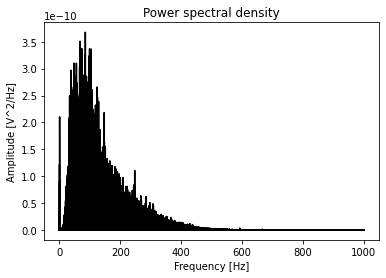

In [ ]:
from scipy.signal import periodogram

def plot_spectrum(signal, fs):
  # plots the frequency spectrum of signal assuming sampling frequency fs
  freqs, Pxx = periodogram(signal, fs=fs, axis=0)

  f = plt.figure()
  ax = f.add_subplot(1,1,1)
  for channel in range(signal.shape[1]):
    _ = ax.plot(freqs,
                Pxx[:, channel],
                color='black')

  _ = ax.set_title('Power spectral density')
  _ = ax.set_xlabel('Frequency [Hz]')
  _ = ax.set_ylabel('Amplitude [V^2/Hz]')

plot_spectrum(emg, fs)

The shape of this spectrum is very typical for EMG signals. However, spectral content at frequencies lower than 10 Hz and higher than 300 Hz probably does not represent physiological information and can be considered as noise. Furthermore, the frequency component at 50 Hz is most likely dominated by power line interference. We will remove all these unwanted compontents with linear time-invariant (LTI) filtering using the scipy.signal library:

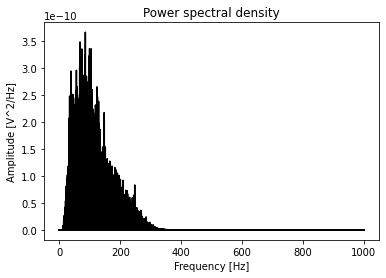

In [ ]:
from scipy.signal import iirnotch, butter, filtfilt

# Use notch filter to remove power line interference
b, a = iirnotch(w0=50.0,
                Q=30.0,
                fs=fs)
emg = filtfilt(b,
               a,
               emg,
               axis=0)

# Use 4:th order Butterworth bandpass filter to remove low- and high frequency noise
b, a = butter(N=4,
              Wn=[10, 300],
              btype='bandpass',
              fs=fs)
emg = filtfilt(b,
               a,
               emg,
               axis=0)

# Plot new EMG spectrum following filtering
plot_spectrum(emg, fs)

# Segmentation
In general terms, statistical classification entails mapping input *features*, typically represented as a list of numbers, to an output *class*, typically represented as an integer. To achieve this, machine learning algorithms are *trained* on examples of valid pairing of features and categories, i.e. a collection of feature vectors and information on which class they each belong to, collectively referred to as the *training set*. To apply this framework to the current problem of inferring which motion is being performed from concurrent EMG, we first need to demarcate what exactly constitutes a single *example*, i.e. an input and an assosciated class. In myoelectric pattern recognition, this separation of the electromyogram into discrete, classifiable parts is typically achieved using a *sliding window* approach. The approach works by placing time windows of contant width at different points along the EMG signal, each with a starting point seperated by a constant distance from that of the previous window. EMG samples falling inside a window can thereafter be used to classify that specific window as belonging to a certain class, i.e. a motion.

To implement this approach, we start by defining the window parameters:

In [ ]:
window_size = 400 #number of samples in each window
step_size = 200 #number of samples window start time translates between consecutive windows
window_overlap = max((window_size - step_size) / window_size, 0)
print('Window overlap is {}'.format(window_overlap))

Window overlap is 0.5


A window size of 400 samples here imply that the classifier that will be implemented will only make use of information from the most recent 200 ms when attempting to infer which movement is being performed. A time lag of 100 ms seperate the staring times of consecutive windows — they thus share 50% of samples.

With a window defined, we let it slide across the entirety of our signals and thusly segment the signal, obtaining a list of overlapping windows:

In [ ]:
windows = []
i = window_size
while i < L:
  window = {}
  window['emg'] = emg[i-window_size:i,:]
  window['stimulus'] = stimulus[i-window_size:i,:]
  window['repetition'] = repetition[i-window_size:i,:]

  windows.append(window)

  i += step_size

example_window = np.random.choice(windows)
print('Each window contains an EMG segment of shape {}'.format(example_window['emg'].shape))
print('Total number of windows is {}'.format(len(windows)))

Each window contains an EMG segment of shape (400, 12)
Total number of windows is 9040


# Feature extraction
As it stands, each window obtained in this way contains 400×12=4800 individual voltages. Recall that the aim is to devise some algorithm that use these values to infer the motion intent of the subject at the time of the window. While it is theoretically possible to find an end-to-end mapping from the 4800-dimensional space of possible EMG segments to the integers 0-17, this would likely require a very complicated function: the relationship between every one of these input voltages and the output motion is clearly nonlinear, as well as highly conditional on every other voltage in the window. This makes the approach of working with raw voltages directly somewhat intractable. Instead, we will try to reduce the number of values needed to describe each window, while at the same time retaining as much relevant information as possible — an approach typically referred to as *feature egineering*, as values computed for this purpose are referred to as features. Importantly, the purpose of a feature is that it should be *discriminative* w.r.t. motion, i.e. that the value it assumes is different depending on which motion class it coincides with. 

In general, designing useful features requires an understanding of the mechanisms underlying the relationship we wish to model. The relevant question to ask in our case would be "What properties an EMG segment do we expect to correlate with concurrent kinematics?". In this tutorial, however, we will circumvent this labor-intensive step by instead applying a set of four well-tried EMG features, listed below, originaly introduced by Hudgins et al. [2] back in the 1990s. These are extracted channel-wise and are popular due to their discriminative (w.r.t. motion) properties, coupled with a low computational complexity (in reality, these will of course have to be computed in real-time):

*   Mean absolute value(MAV): The mean of the absolute value of the samples in the EMG window.
*   Zero crossings (ZC): The number of times the EMG waveform switches sign (i.e. crosses zero).
*   Slope sign changes (SSC): The number of times the slope of the EMG waveform switches sign.
*   Waveform length (WL): The length of the EMG waveform.




In [ ]:
def mean_absolute_value(window_emg):
  # computes the MAV feature of window_emg
  mav = np.mean(np.abs(window_emg), axis=0)
  return mav

def zero_crossings(window_emg):
  # computes the ZC feature of window_emg
  zc = np.sum(window_emg[1::,:]*window_emg[:-1:,:]<0, axis=0)
  return zc

def slope_sign_changes(window_emg):
  # computes the SSC feature of window_emg
  dif = np.diff(window_emg,n=1,axis=0)
  ssc = (dif > 0)*1 - (dif < 0)*1
  ssc = np.sum(np.abs(np.diff(ssc,n=1,axis=0)) > 1,axis=0)
  return ssc

def waveform_length(window_emg):
  # computes the WL feature of window_emg
  wl = np.sum(np.abs(window_emg[1::,:] - window_emg[:-1:,:]), axis=0)
  return wl

We now iterate over all available windows and extract the features from the EMG segments contained therein:

In [ ]:
for window in windows:
  window_emg = window['emg']

  window_mav = mean_absolute_value(window_emg)
  window_zc = zero_crossings(window_emg)
  window_ssc = slope_sign_changes(window_emg)
  window_wl = waveform_length(window_emg)

  window['features'] = np.hstack((window_mav,
                                  window_zc,
                                  window_ssc,
                                  window_wl))

As we compute 4 EMG features for each one of the available 12 channels, the length of a feature vector that represents a window will be 4*12=48: 

In [ ]:
example_window = np.random.choice(windows)
num_features = example_window['features'].size
assert num_features == 4*num_channels
print('Total number of features per window is {}'.format(num_features))

Total number of features per window is 48


So far, we have only considered how to construct feature vectors, i.e. the input to a would-be classifier. However, training a classifier with machine learning also requires ground-truth outputs, i.e. the motion intent of the subject at the time when features were acquired. Here, the motion class of each window will be set by a simple majority vote over the samples of the stimuli values contained in each window, as the visual cue presented to the subject can be considered a somewhat robust proxy for the concurrent motion intent. We will make use of the same scheme in order to obtain a single value representing the repetition affiliation of each feature window.

In [ ]:
def majority_vote(segment):
  # returns the most numerous element in segment
  values, counts = np.unique(segment, return_counts=True)
  mode = values[np.argmax(counts)]
  return mode

We apply this operation iteratively over all available data windows segmented previously:

In [ ]:
for window in windows:
  window_stimulus = window['stimulus']
  window_repetition = window['repetition']

  window['stimulus_univariate'] = majority_vote(window_stimulus)
  window['repetition_univariate'] = majority_vote(window_repetition)

We now have everything needed to train the pattern recognition algorithm (a classifier): a set of feature vectors, each with an assosciated ground-truth class (i.e. motion). The goal is now to find some function or algorithm that, when applied to a feature vector, is able to return which class it is a member of. Recall that for this to be possible in the first place, the chosen feature set must be *discriminative* w.r.t. class, i.e. the features typical for each class must be sufficiently different from the features typical for each other class — if the values of the features are independent of the value of the target class, they will clearly be useless for the purpose of determining that class.

Before we move on, it would thus be nice to get some sense of whether or not our chosen feature set is discriminative w.r.t. motion. For this reason, we would like to plot the features of different windows and see if they appear different for windows originating from different motions. However, as each feature vector is a point in a 48-dimensional space, it might not be obvious how to visualize their distribution. The simplest approach is arguably to use a dimensionality-reduction technique to see if some information on the quality of features can be gleaned from a more low-dimensional representation. For this purpose, we will use principal component analysis (PCA) to project each feature vector along the directions in feature space with most variance across windows:

In [ ]:
from sklearn.decomposition import PCA

features = [window['features'] for window in windows]
motions = [window['stimulus_univariate'] for window in windows]

pca = PCA()
pca.fit(features)
pcs = pca.transform(features)

We plot the values of the two most significant principal components for all feature vectors. Each point thus corresponds to a single window and is colored according to the motion class to which it belongs.

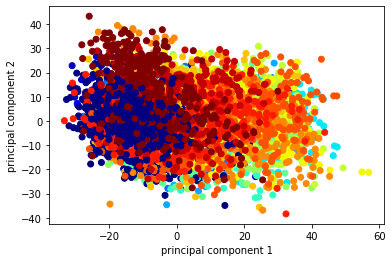

In [ ]:
pc1 = pcs[:,0]
pc2 = pcs[:,1]

cmap = mpl.cm.get_cmap('jet')
color = [(motion / num_motions) for motion in motions]

f = plt.figure()
ax = f.add_subplot(1, 1, 1)
_ = ax.scatter(pc1, pc2, cmap=cmap, c=color)
_ = ax.set_xlabel('principal component 1')
_ = ax.set_ylabel('principal component 2')


From a cursory glance, it appears that features are clustered around slightly different centres depending on color (i.e. class affiliation). This is promising, but we can include one additional principal compontent and see if the seperation of classes improves even further. As each window will then be described by 3 values, we need to plot this in 3D:

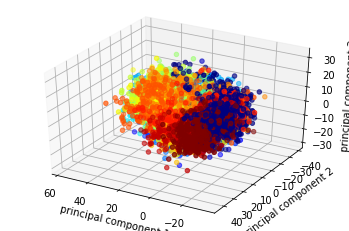

In [ ]:
pc3 = pcs[:,2]

from mpl_toolkits import mplot3d

f = plt.figure()
ax = plt.axes(projection='3d')
_ = ax.scatter3D(pc1, pc2, pc3, cmap=cmap, c=color)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')
ax.view_init(35, 120)

Although there is obviously large overlap, the separation of motion clusters becomes somewhat more pronounced when we add an additional component; by utilizing all 48 feature dimensions, the 18 motion classes can hopefully be seperated by a classifier.

# Training the Classifier
Before the classifier can be trained, we need to split all available examples into two parts: the training set and the test set. The training set will be used to optimize the parameters of the classifier. The test set will be used to estimate the out-of-sample performance of the classifier, i.e. its performance on unseen data not used during training. We can use the repetition affiliation of each window as the basis for this split: windows originating from repetitions 1-4 will constitute the training set, while windows originating from repetitions 5-6 will constitute the test set.

In [ ]:
training_repetitions = [1,2,3,4]
test_repetitions = [5,6]

X_train = []
y_train = []

X_test = []
y_test = []

for window in windows:
  if window['repetition_univariate'] in [1,2,3,4]:
    X_train.append(window['features'])
    y_train.append(window['stimulus_univariate'])
  elif window['repetition_univariate'] in [5,6]:
    X_test.append(window['features'])
    y_test.append(window['stimulus_univariate'])

print('Number of training windows is {}.'.format(len(y_train)))
print('Number of test windows is {}.'.format(len(y_test)))

#Convert results into numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

Number of training windows is 6039.
Number of test windows is 3001.


With a training set and a test set defined, the text step is to *standardize* our features, i.e. enforce zero mean and unit variance for all features across windows. This step is crucial, as it ensures that no feature is given undue weight in the classification procedure simply by virtue of having larger value across most examples. We will use the training set to estimate the mean and variance of the features, and rescale the features of both the training and the test set accordingly:

In [ ]:
for feature in range(num_features):
  feature_mean = np.mean(X_train[:, feature])
  feature_std = np.std(X_train[:, feature])

  X_train[:, feature] = (X_train[:, feature] - feature_mean) / feature_std
  X_test[:, feature] = (X_test[:, feature] - feature_mean) / feature_std


With a standardized training set, we are finally ready to train a classifier with machine learning. For the purposes of this tutorial, we will import an already available implementation of a linear *support vector machine* directly from the the sklearn library, and train it using the pairings of feature vectors and motion classes contained in our training set:


In [ ]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear')
_ = classifier.fit(X_train, y_train)


While the inner workings of support vector machines lie outside the scope of this tutorial, figure 3 can give an intuitive understanding of their fundamental principle. In essence, they work by finding the hyperplane that achieves maximum margin width between two classes in feature space. New feature vectors can thereafter be classified in accordance with which side of this line they end up on.

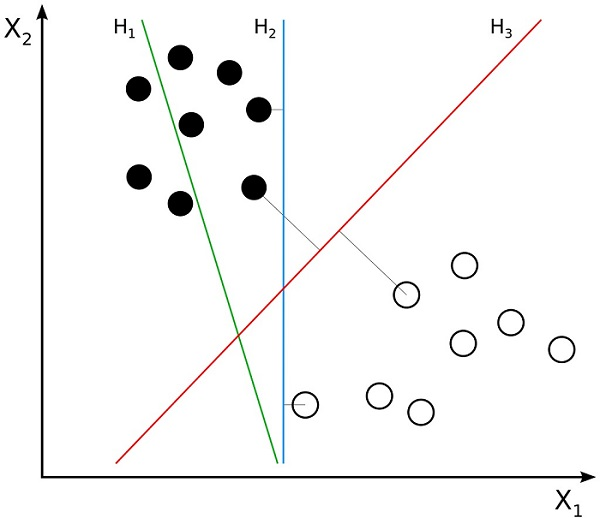

Figure 3. Simple examples of 3 linear decision thresholds. The line H3 seperates the two classes (black and white) with the widest possible margin.

For the interested reader, there is no shortage of comprehensive explanations of the support vector machine framework available online (see, for example, [the wikipedia page](https://en.wikipedia.org/wiki/Support-vector_machine)). There you can find out, for example, how the framework is extended to handle problems with more than 2 classes, as is the case here.


# Performance evaluation
With a classifier trained, we wish to obtain some measure or metric of its performance. A  first step towards this end is to let the support vector classifier actually classify the windows constituting our training set:

In [ ]:
y_pred_train = classifier.predict(X_train)

We can now plot the output and compare it to our ground truth stimulus signal:

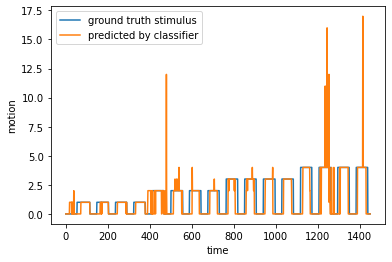

In [ ]:
view_window = np.arange(0,1450,1)

f = plt.figure()
ax = f.add_subplot()

_ = ax.plot(y_train[view_window], label='ground truth stimulus')
_ = ax.plot(y_pred_train[view_window], label='predicted by classifier')

_ = ax.legend()
_ = ax.set_xlabel('time')
_ = ax.set_ylabel('motion')

Across the first 3 motions, the output of the classifier clearly coincides with the stimuli most of the time, with some salient (literally!) exceptions.

To condense our observation into a single, somewhat informative, number, we define the accuracy as the proportion out of all EMG segment that are correctly classified:

In [ ]:
def accuracy(y_pred, y_true):
  acc = np.sum(y_pred == y_true) / y_true.size
  return acc

We first compute the accuracy of the classifier on the training set:

In [ ]:
accuracy_train = accuracy(y_pred_train, y_train)
print('Accuracy on training set: {:.3f}'.format(accuracy_train))

Accuracy on training set: 0.756


This looks somewhat promising (more than 75% of windows have their motion inferred correctly), but an important quesion to ask is: does the performance generalize? Can we expect the classifier to correctly classify novel EMG segment that it has not previously seen? This would clearly be necesary in a real prosthesis control scenario. To get some indication, we can compute the accuracy of the classifier on the test set:

In [ ]:
y_pred_test = classifier.predict(X_test)
accuracy_test = accuracy(y_pred_test, y_test)

print('accuracy on test set: {:.3f}'.format(accuracy_test))

accuracy on test set: 0.670


Apparrantly, the correctness of the classifier drops noticably when applied to EMG segments not previously seen. This is expected: the distribution of training set feature vectors is seldom identical to the distribution of test set feature vectors. Nevertheless, the difference between training set accuracy and test set accuracy can be considered an important measure of *overfitting*, i.e. how much the classifier has been adapted to the minutiae of the training data instead of modelling more general principles. In this case, the difference arguably lies within acceptable limits

Before we end the tutorial, we will try to get some further understanding of the performance of our classifier. As it stands, the accuracy gives a condensed but narrow view of how the classifer performs across all available test examples. By computing the *confusion matrix*, we can get a somewhat more fine-grained understanding of how the classifier performs across all of the motion classes seperately:

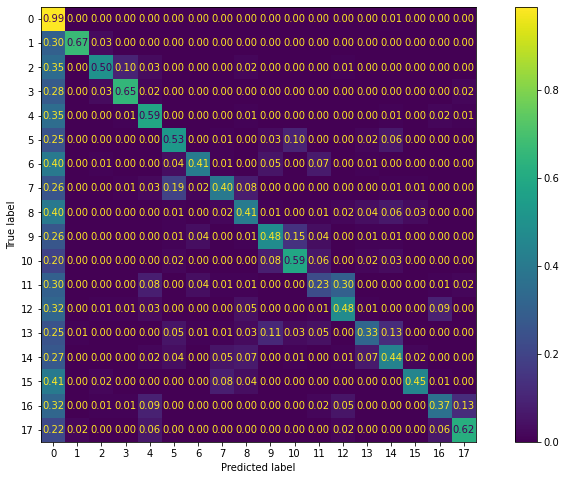

In [ ]:
from sklearn.metrics import plot_confusion_matrix
f = plt.figure(figsize=(14, 8))
ax = f.add_subplot(1, 1, 1)
_ = plot_confusion_matrix(estimator=classifier,
                          X=X_test,
                          y_true=y_test,
                          normalize='true',
                          ax=ax,
                          values_format='.2f')

From this we can read, among other things, that the classifier is significantly better at detecting rest (the class 0) than any of the motions. Furthermore, all of the motions seem to oftentimes be misclassified as rest. This is likely a result of the distribution of the training data: the plurality of windows are labelled as belonging to the rest class 0. A natural next step could therefore be to *balance* the training set, i.e. make sure that the classifier is trained on data consisting of approximately the same number of examples pertaining to each motion class.

# Questions
1. Try some other reasonable values for the parameter of the sliding window (width and step size) and rerun all code blocks after the segmentation. How does the number of resulting examples change as a function of step size? What is the impact on the final test set accuracy? Also give some potential drawbacks of choosing a very large or very small window size for this specific application (prosthesis control).
2. In this tutorial, we used a simple linear support vector classifier (sklearn.svm.SVC). The sklearn library also contains an abundance of other classifiers of varying complexity, most of which are likewise trainable with a single line of Python code. Try to replace the support vector classifier with some other choice(s) (suggestions: sklearn.neighbors.KNeighborsClassifier, sklearn.neural_network.MLPClassifier, and/or sklearn.ensemble.RandomForestClassifier). Does changing the classifier significantly impact the accuracy on the training set and/or the test set?
3. (Optional) Try to extend the feature set by implementing and extracting some other 'summary' of EMG segments (e.g. statistics such as variance, skew, curtosis). Does the inclusion of your novel feature(s) improve the final accuracy of the classifier model?

**Please write some comments on this tutorial in this cell. After you have commented the tutorial, save it and print to pdf (Ctrl-P) and hand it in using Canvas.**



# References



1.   Manfredo Atzori et al., Electromyography data for non-invasive naturally-controlled robotic hand prostheses, Scientific Data 1, 2014.
2.   Hudgins et al., *A new strategy for multifunctional myoelectric control*, IEEE transactions on Biomedical Engineering **40**, 1993.




